- Извлечь разметку
    - Эмоция
    - Слово
    - Наличие артефактов
    - Разные субъекты
    - Время попытки у одного субъекта

- Найти важные признаки
    - Выделить ближайшие каналы
    - Посчитать средние эпохи по эмоциям
    - Найти: P1, N170, EPN, LPC
        - Время 
            - 165-195
            - 250-290
            - 300-400
            - 480-530
        - Карту каналов
        - 
    - Найти ближайшие каналы: Cz, CPz, PO3, PO4, P7, P8, PO7, PO8

- Удалить выбросы

In [107]:
import mne
import numpy as np
import os

In [127]:
import pandas as pd

In [108]:
file_path = '../dataset/DataRawSet_256/DataRawSet_256/k1.set'

In [109]:
raw = mne.io.read_raw_eeglab(file_path, eog='auto', preload=True)

/home/noomkcalb/Documents/IsoEEG-GAN/brainhack/lib/python3.7/site-packages/pymatreader/utils.py:217: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Reading /home/noomkcalb/Documents/IsoEEG-GAN/eeggan/investigation/../dataset/DataRawSet_256/DataRawSet_256/k1.fdt
Reading 0 ... 505794  =      0.000 ...  1975.758 secs...


/tmp/ipykernel_237115/3053589399.py:1: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['EOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(file_path, eog='auto', preload=True)


In [111]:
raw.ch_names[0:5]

['O1', 'O2', 'P7', 'P3', 'Pz']

### Reference installation

In [112]:
import matplotlib.pyplot as plt

Opening raw-browser...


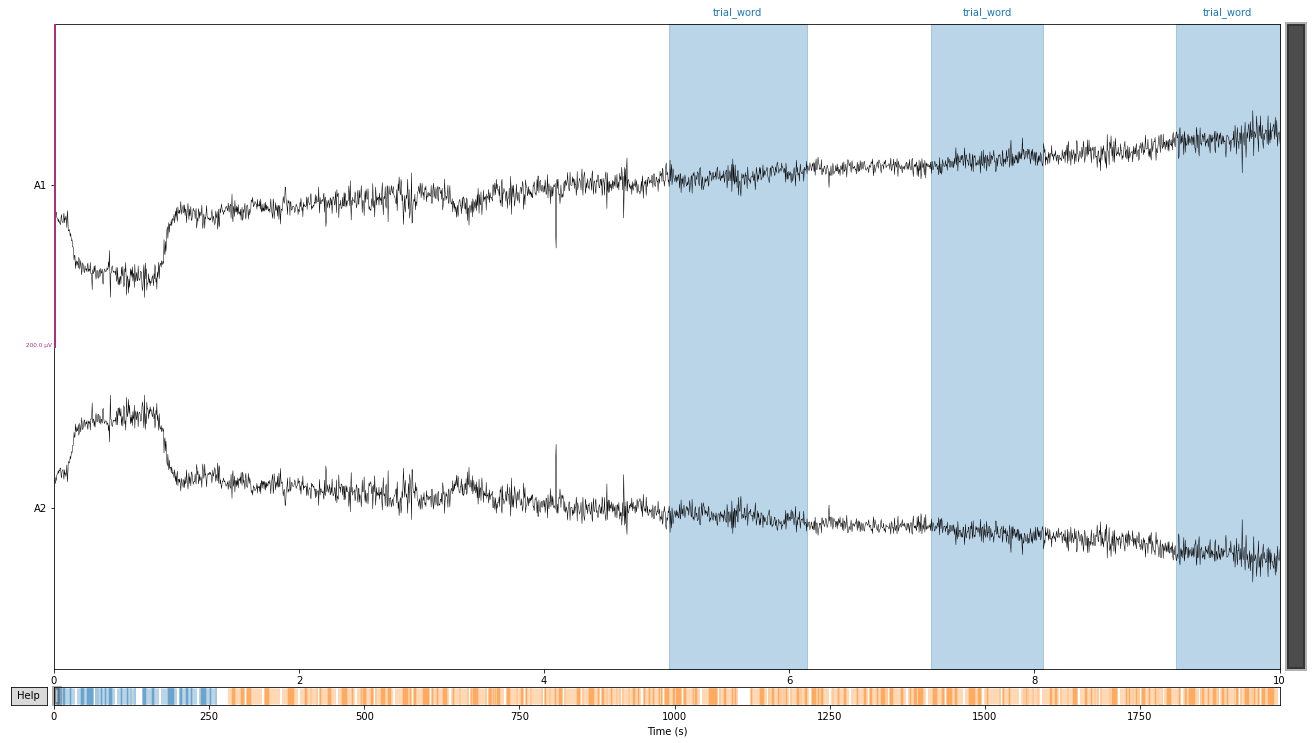

In [113]:
raw.copy().pick(['A1', 'A2']).plot(scalings={'eeg': 1e-4})
plt.show()

In [114]:
cz_before, _ = raw.copy().pick(['Cz'])[:]

In [115]:
raw = raw.set_eeg_reference(['A1', 'A2'])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


In [116]:
cz_after, _ = raw.copy().pick(['Cz'])[:]

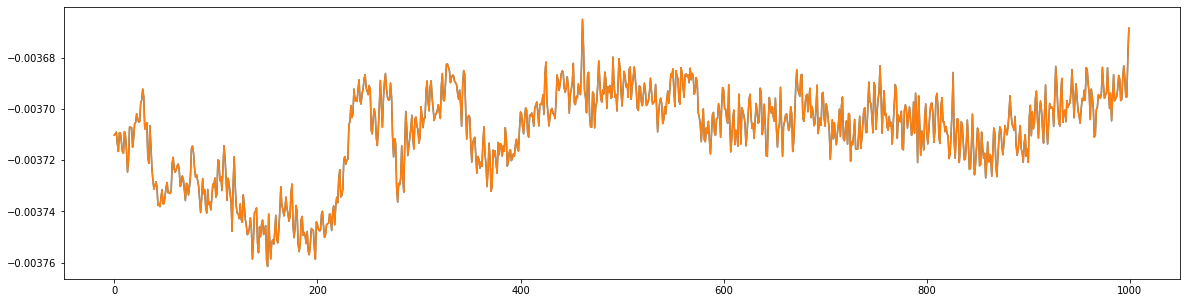

In [117]:
plt.figure(figsize=(20, 5))

plt.plot(cz_before[0, 0:1000])
plt.plot(cz_after[0, 0:1000])

The signal is unchanged?

Opening raw-browser...


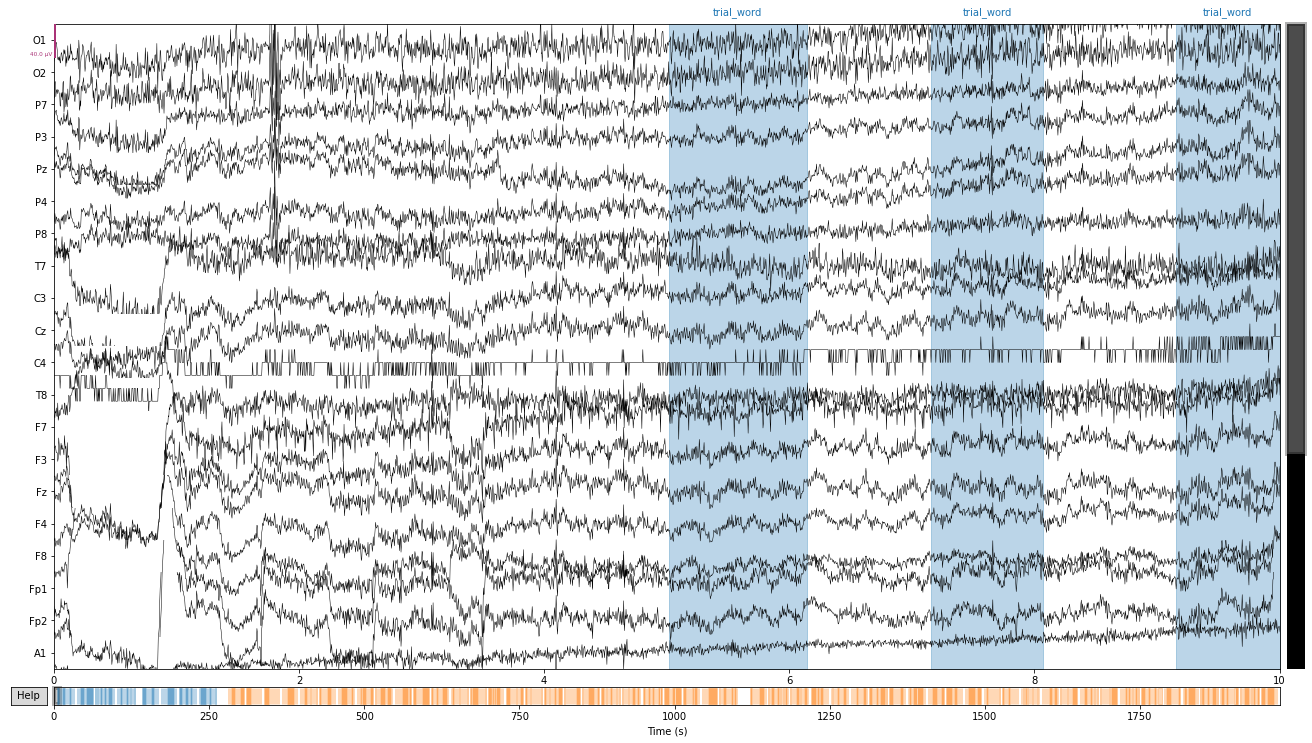

In [118]:
raw.plot()
plt.show()

### Signal filtering

Should it be performed before or after rereferencing?

Which filter should be used

In [119]:
import scipy
import numpy.fft as fft
from scipy.signal import welch
from  scipy.signal import freqz, group_delay #funkcja obliczająca funkcję systemu
from  scipy.signal import firwin, firwin2     # funkcje do projektowania filtrów FIR
from  scipy.signal import butter, buttord     # funkcje do projektowania filtrów  
from  scipy.signal import cheby1, cheb1ord    # funkcje do projektowania filtrów 
from  scipy.signal import cheby2, cheb2ord    # funkcje do projektowania filtrów 
from  scipy.signal import ellip, ellipord     # funkcje do projektowania filtrów eliptycznych
from  scipy.signal import iirnotch
from  scipy.signal import lfilter, filtfilt # funkcje do aplikowania filtrów

In [120]:
Fs = int(raw.info['sfreq'])

### Default filtering

In [121]:
raw = raw.filter(0.1, 30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8449 samples (33.004 sec)



In [122]:
raw = raw.notch_filter(50, notch_widths=3)

Setting up band-stop filter from 48 - 52 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 48.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 47.75 Hz)
- Upper passband edge: 52.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 52.25 Hz)
- Filter length: 1691 samples (6.605 sec)



### Recommended filtering

In [101]:
[nb, na] = iirnotch(50,Q=30,fs=Fs)
[b, a] = butter(2,0.1,btype='highpass', fs=Fs)
[b1, a1] = butter(2,30,btype='lowpass', fs=Fs)

Checking filter params

In [92]:
# help(raw.filter)

In [93]:
# help(raw.notch_filter)

In [ ]:

sf = filtfilt(b,a,sref)
sf = filtfilt(b1,a1,sf)
sf = filtfilt(nb,na,sf)

Opening raw-browser...


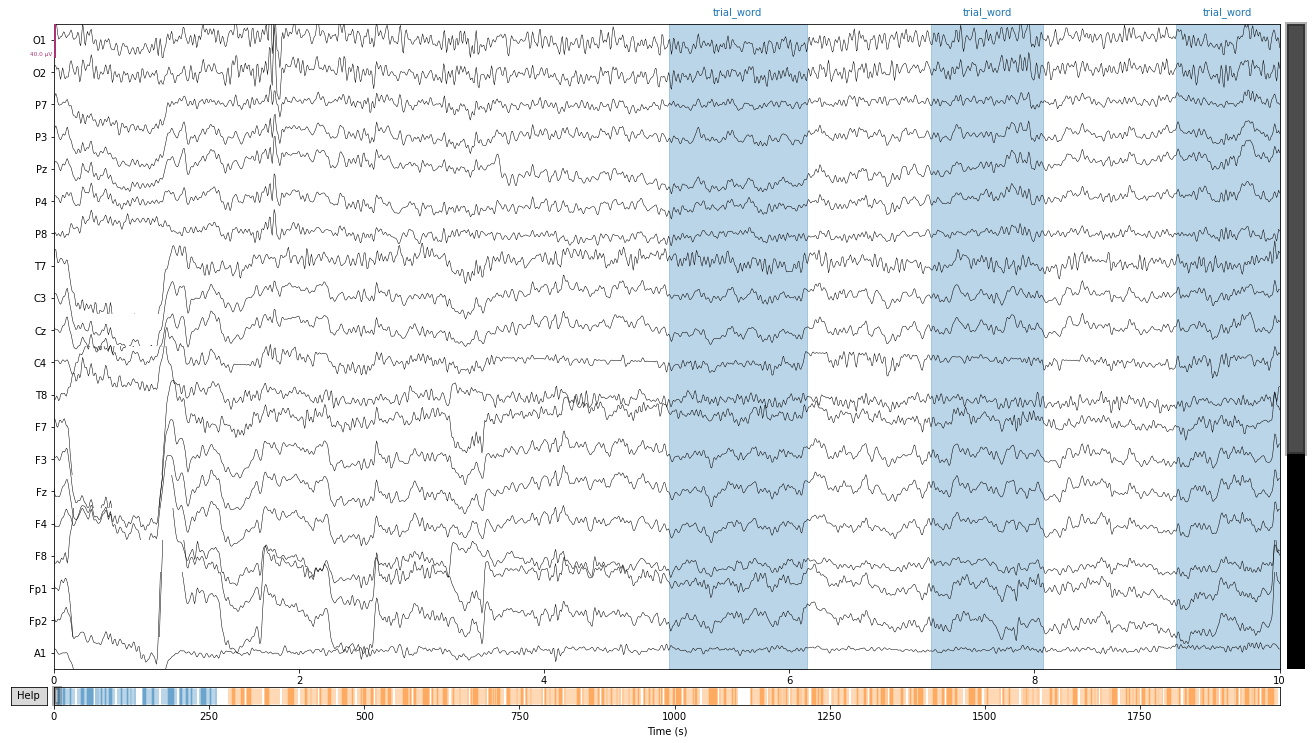

In [123]:
raw.plot()
plt.show()

### Аннотации в датасете

In [141]:
from scipy.io import loadmat

In [192]:
from pymatreader import read_mat

In [195]:
def read_tag_type(fname, uint16_codec=None):
    eeg = read_mat(fname, uint16_codec=uint16_codec)
    eeg = eeg.get('EEG', eeg)  # handle nested EEG structure
    eeg = Bunch(**eeg)
    return eeg
    tags_type = eeg.event['event_info'] #podmienilam tag type na event info

    return tags_type

In [196]:
e = read_tag_type(file_path)

In [203]:
e['event'].keys()

dict_keys(['type', 'latency', 'duration', 'tag_type'])

In [219]:
words_df = pd.DataFrame(e['event']['tag_type'])

In [221]:
words_df['block'].value_counts()

1    405
2    405
0    120
Name: block, dtype: int64

In [230]:
words_df['wordCategory'].value_counts()

23.0    30
18.0    30
3.0     30
8.0     30
26.0    30
22.0    30
1.0     30
19.0    30
13.0    30
15.0    30
10.0    30
20.0    30
4.0     30
6.0     30
7.0     30
24.0    30
12.0    30
27.0    30
9.0     30
16.0    30
17.0    30
5.0     30
2.0     30
11.0    30
14.0    30
25.0    30
21.0    30
Name: wordCategory, dtype: int64

In [347]:
words_df.iloc[-10:]

,block,category,word,decision,color,test,wordCategory,valence,arousal,significance,nbOfLetters,dominance,origin,concretness,imegability,ageOfAquisition,ln_KazjocFreq,RT
920,2,1,"{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...",0,14.0,"{'group_rank': 2, 'group': 4.8, 'personal': 7}","{'group_rank': 2, 'group': 3.96, 'personal': 4}","{'group_rank': 2, 'group': 3.86, 'personal': 1}",6.0,4.500000,6.340000,4.020000,5.800000,9.780000,6.76,1.070312
921,2,1,"{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...",1,14.0,"{'group_rank': 2, 'group': 5.02, 'personal': 3}","{'group_rank': 2, 'group': 3.86, 'personal': 5}","{'group_rank': 2, 'group': 3.74, 'personal': 6}",6.0,4.367347,5.660000,3.240000,6.200000,10.140000,5.78,0.620117
922,2,1,"{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...",1,14.0,"{'group_rank': 2, 'group': 5.4, 'personal': 7}","{'group_rank': 2, 'group': 4.16, 'personal': 1}","{'group_rank': 2, 'group': 3.78, 'personal': 4}",4.0,5.080000,4.820000,5.420000,5.880000,9.180000,6.42,0.620605
923,2,1,"{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...",1,14.0,"{'group_rank': 2, 'group': 5.06451612903226, '...","{'group_rank': 2, 'group': 4.08108108108108, '...","{'group_rank': 2, 'group': 3.60526315789474, '...",11.0,5.705882,6.257143,4.923077,3.037037,13.595238,1.10,0.670410
924,2,1,"{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...",1,14.0,"{'group_rank': 2, 'group': 5.32, 'personal': 6}","{'group_rank': 2, 'group': 3.8, 'personal': 5}","{'group_rank': 2, 'group': 3.68, 'personal': 1}",7.0,5.380000,5.980000,5.340000,3.720000,11.480000,4.54,0.503418
925,2,1,"{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...",1,14.0,"{'group_rank': 2, 'group': 5.32, 'personal': 5}","{'group_rank': 2, 'group': 3.82, 'personal': 4}","{'group_rank': 2, 'group': 3.48, 'personal': 1}",10.0,5.740000,6.100000,5.120000,5.160000,10.680000,4.34,0.637207
926,2,1,"{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...",1,14.0,"{'group_rank': 2, 'group': 5.45945945945946, '...","{'group_rank': 2, 'group': 4.05263157894737, '...","{'group_rank': 2, 'group': 3.46666666666667, '...",5.0,5.684211,5.476190,4.500000,3.900000,12.225000,3.71,0.803711
927,2,1,"{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...",1,14.0,"{'group_rank': 2, 'group': 4.94, 'personal': 6}","{'group_rank': 2, 'group': 4, 'personal': 1}","{'group_rank': 2, 'group': 3.4, 'personal': 1}",4.0,6.960000,6.040000,5.560000,5.660000,11.300000,5.29,0.836914
928,2,1,"{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...",1,14.0,"{'group_rank': 2, 'group': 5.38, 'personal': 2}","{'group_rank': 2, 'group': 3.86, 'personal': 4}","{'group_rank': 2, 'group': 3.86, 'personal': 3}",6.0,5.580000,5.980000,3.860000,6.460000,8.080000,8.41,1.137207
929,2,1,"{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...","{'s0': [b''], 's1': [b'MCOS'], 's2': [b'string...",1,14.0,"{'group_rank': 2, 'group': 5.38, 'personal': 5}","{'group_rank': 2, 'group': 3.92, 'personal': 3}","{'group_rank': 2, 'group': 3.5, 'personal': 6}",9.0,5.560000,5.800000,3.960000,6.860000,8.

In [242]:
words_df['decision'].iloc[-1]

{'s0': [b''],
 's1': [b'MCOS'],
 's2': [b'string'],
 'arr': [array([3707764736,          2,          1,          1,       2789,
                  1], dtype=uint32)]}

In [246]:
valences_df = pd.DataFrame(words_df['valence'].tolist())

In [248]:
valences_df['group_rank'].value_counts()

3.0    270
1.0    270
2.0    270
Name: group_rank, dtype: int64

In [225]:
# words_df

In [210]:
e['event']['tag_type'][-]['word']

{'s0': [b''],
 's1': [b'MCOS'],
 's2': [b'string'],
 'arr': [array([3707764736,          2,          1,          1,       2761,
                  1], dtype=uint32)]}

In [129]:
annotations_df = pd.DataFrame(raw.annotations)

In [131]:
annotations_df['description'].value_counts()

word          810
trial_word    120
Name: description, dtype: int64

<AxesSubplot:ylabel='Frequency'>

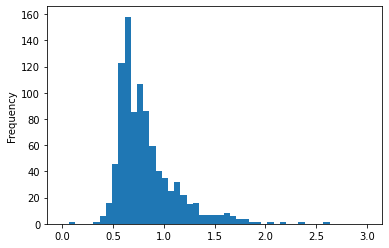

In [135]:
annotations_df['duration'].plot(kind='hist', bins=np.linspace(0, 3, 50))

### Epoching

In [257]:
events_matrix, _ = mne.events_from_annotations(raw)

Used Annotations descriptions: ['trial_word', 'word']


In [265]:
events_df = pd.DataFrame(events_matrix, columns=['onset', '.', 'event'])

In [ ]:
mne.Epochs(raw)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
925    2.0
926    2.0
927    2.0
928    2.0
929    2.0
Name: group_rank, Length: 930, dtype: float64

In [287]:
events_df['event2'] = valences_df['group_rank'].fillna(0).astype(int)

In [288]:
events_matrix_modified = events_df[['onset', '.', 'event2']].values

In [289]:
events_matrix_modified

array([[  1285,      0,      0],
       [  1831,      0,      0],
       [  2343,      0,      0],
       ...,
       [503518,      0,      2],
       [503988,      0,      2],
       [504538,      0,      2]])

In [338]:
epochs = mne.Epochs(raw, events_matrix_modified, tmin=-0.2, tmax=0.8, preload=True, baseline=(None, 0))

Not setting metadata
930 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 930 events and 257 original time points ...
0 bad epochs dropped


In [339]:
mapping = {
    'Cz': 'Cz',
    'CPz': 'Pz',
    'PO3': 'P3', 
    'PO4': 'P4',
    'P7': 'P7',
    'P8': 'P8',
    'PO7': 'O1',
    'PO8': 'O2'
}

In [340]:
# help(epochs.copy().pick('Cz')['1'].average().plot)

In [341]:
parts_mapping = {
    'P1': (0.165, 0.195),
    'N170': (0.250, 0.290),
    'EPN': (0.300, 0.400),
    'LPC': (0.480, 0.530)
}

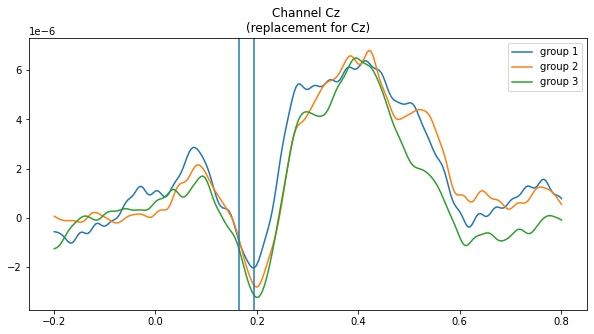

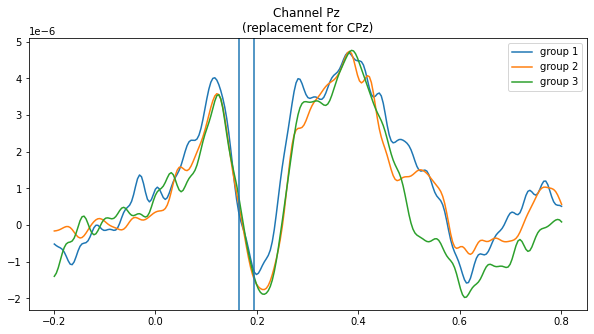

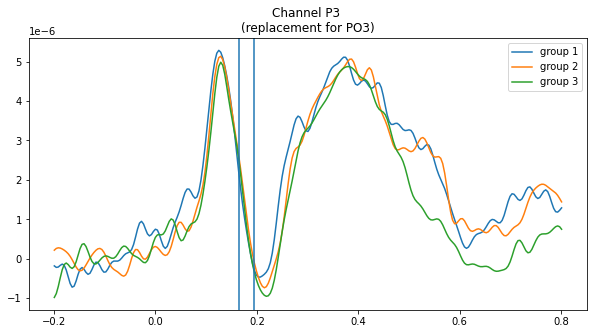

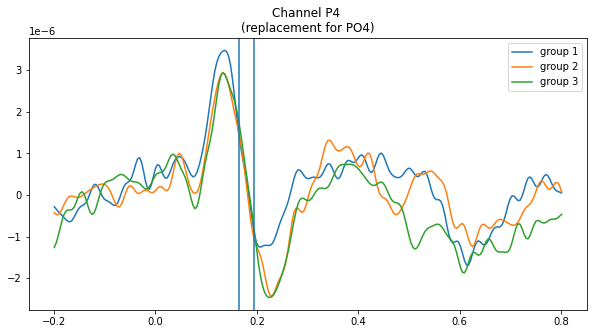

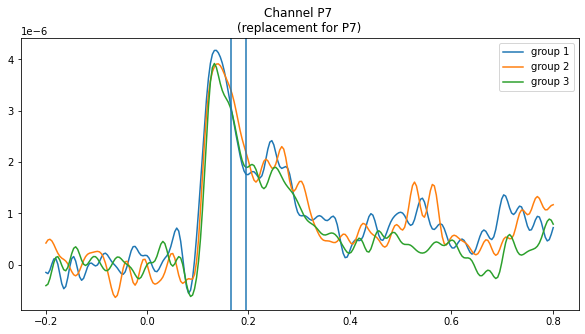

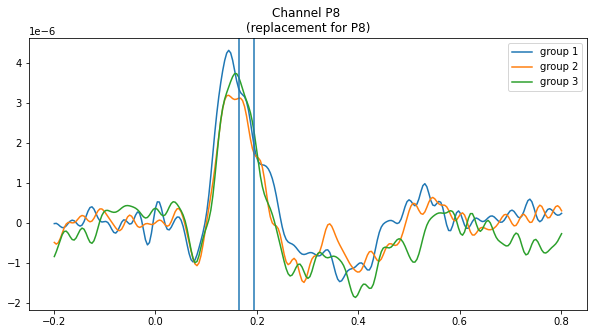

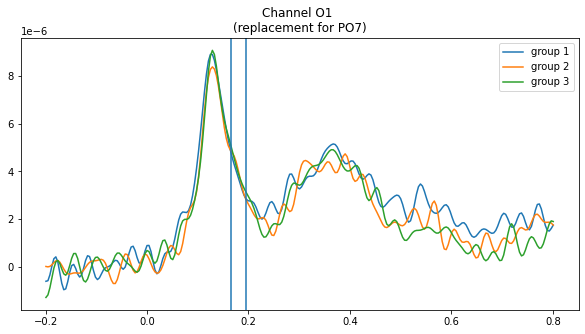

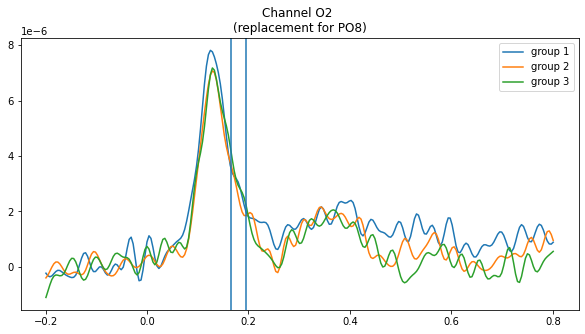

In [355]:
part_highlighted = 'P1'

for channel_replaced, channel in mapping.items():
    plt.figure(figsize=(10, 5))
    
    for group in list(['1', '2', '3']):
        channel_data = -epochs.copy().pick(channel)[group].average().get_data()
        channel_time = epochs.times
        plt.plot(channel_time, channel_data.T, label=f'group {group}')
    plt.title(f'Channel {channel} \n(replacement for {channel_replaced})')
    
    start, end = parts_mapping[part_highlighted]
    plt.axvline(start)
    plt.axvline(end)
    
    plt.legend()
    plt.show()

### TODO stat.test

### Coherency implementation

In [356]:
from mne.time_frequency import csd_fourier, csd_multitaper, csd_morlet

In [380]:
picked_channel = list(mapping.values())

In [403]:
picked_channel

['Cz', 'Pz', 'P3', 'P4', 'P7', 'P8', 'O1', 'O2']

In [472]:
import networkx as nx

In [434]:
bands = {
    'theta': (4, 7),
    'alpha': (8, 14),
    'beta': (15, 30)
}

In [554]:
events = ['1', '2', '3']

In [555]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

channel_positions_df = pd.DataFrame(ten_twenty_montage.get_positions()['ch_pos']).T

channel_positions_df.columns = ['x', 'y', 'z']

pos = dict(zip(picked_channel, channel_positions_df.loc[picked_channel][['x', 'y']].values))

Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/270 [00:00<?,       ?it/s]

[done]
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/270 [00:00<?,       ?it/s]

[done]
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/270 [00:00<?,       ?it/s]

[done]


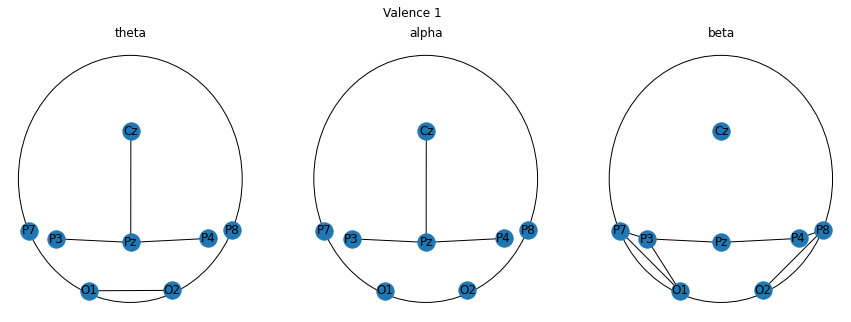

Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/270 [00:00<?,       ?it/s]

[done]
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/270 [00:00<?,       ?it/s]

[done]
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/270 [00:00<?,       ?it/s]

[done]


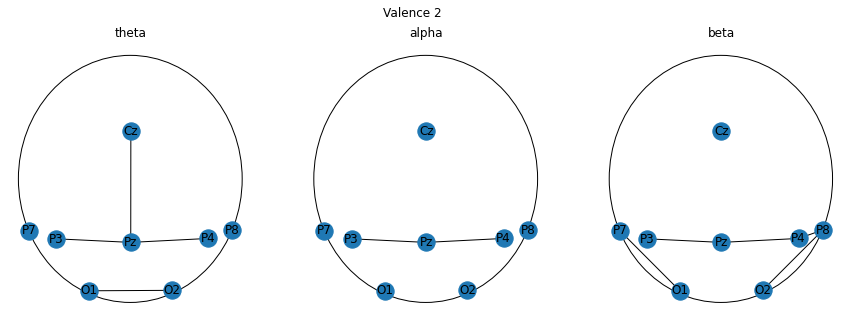

Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/270 [00:00<?,       ?it/s]

[done]
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/270 [00:00<?,       ?it/s]

[done]
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/270 [00:00<?,       ?it/s]

[done]


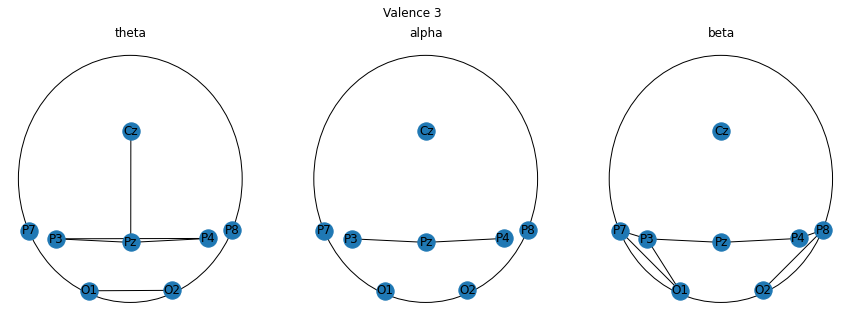

In [566]:
for event in events:
    plt.figure(figsize=(15, 5))
    
    for fig, (band_name, (b_start, b_end)) in enumerate(bands.items()):
        csd = csd_fourier(epochs[event].copy().pick(picked_channel), fmin=b_start, fmax=b_end)
        
        cross_spectra_matrix = np.abs(csd.mean().get_data())
        
        coherencies = []

        for i, c1 in enumerate(picked_channel):
            for j, c2 in enumerate(picked_channel):
                if i >= j:
                    continue
                coherency = cross_spectra_matrix[i][j] / np.sqrt(cross_spectra_matrix[i][i] * cross_spectra_matrix[j][j])

                coherencies.append((c1, c2, coherency))
                
        coherencies_df = pd.DataFrame(coherencies, columns=['c1', 'c2', 'COH'])
        selected_edges = coherencies_df[coherencies_df['COH'] > 0.8][['c1', 'c2']].values
        
        plt.subplot(1, 3, fig + 1)
        g = nx.Graph()
        g.add_nodes_from(picked_channel)
        g.add_edges_from(selected_edges)
        
        ax = plt.gca()
        c = plt.Circle((0, -0.04), 0.08, fill=False, edgecolor='black')
        ax.add_patch(c)
        nx.draw(g, pos=pos, with_labels=True)
    
        plt.title(f'{band_name}')
    plt.suptitle(f'Valence {event}')
    plt.show()

### DTF implementation